In [2]:

# Written by Kha Vo, University of Technology Sydney
# corresponding to the article: The Magic of Reinforcement Learning Part 1
# https://voanhkha.github.io/2019/11/29/magic_rl_p1/

# Email: kha.vo@uts.edu.au
# www.kaggle.com/khahuras
# www.github.com/voanhkha

# Gentle Request: I am happy if you re-use the materials here or the article
# Please just kindly cite it by simply copying the source link, or my name.
# So much thanks!
# Kind regards,
# Kha Vo.


In [5]:
import numpy as np, pandas as pd, os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')
import time
from IPython import display
%matplotlib notebook
%matplotlib notebook

from itertools import count
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class GridWorld:
    
    def save_render(self, path='frames/sample.png', title='title'):
        colors = {'red':[230, 32, 32], 'green':[40,255,40]}
        M = np.zeros((self.width, self.height, 3), dtype=np.uint8)
        for m, c in zip(self.map, colors):
            for i in range(self.width):
                for j in range(self.height):
                    if m[i,j] != 0: M[i,j,:] = colors[c]
        plt.imshow(M) 
        plt.axis('off')
        plt.suptitle(title, fontsize=16)
        #plt.tight_layout()
        #plt.subplots_adjust(top=0.88)
        plt.savefig(path, bbox_inches='tight')
        #plt.show()
  
       
    def plot_map(self, plot=True):
        colors = {'red':[230, 32, 32], 'green':[40,255,40]}
        M = np.zeros((self.width, self.height, 3), dtype=np.uint8)
        for m, c in zip(self.map, colors):
            for i in range(self.width):
                for j in range(self.height):
                    if m[i,j] != 0: M[i,j,:] = colors[c]
        if plot: 
            plt.imshow(M) 
            plt.axis('off')
        return M

    def pad_with(self, vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 10)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value    
    
    def __init__(self, width=20, height=20, agent_types=['predator', 'prey'], 
                 n_agents_each_type=[4,4], terminal_frame=20):
        self.width, self.height = width, height
        self.agent_types = agent_types
        self.n_agent_types = len(self.agent_types)
        self.n_agents_each_type = n_agents_each_type
        self.map = np.zeros((self.n_agent_types, width, height), dtype=int)
        self.occupiable = np.zeros((width, height), dtype=bool)
        self.agents = {}
        self.monitor =  { t: [ [ [ ] for j in range(width) ]  for i in range(height) ] for t in self.agent_types}
        self.init_agents(init_pos='random')
        self.move_offset = [[0,1],[0,-1],[1,0],[-1,0], [0,0]]
        self.done = False
        self.terminal_frame = terminal_frame
        self.count_frame = 0
        self.global_reward = 0
        
    def sample_random_actions(self):
        acts = [random.choices( range(len(self.move_offset)), k=N ) 
                for N in self.n_agents_each_type]
        return acts
        
    def init_agents(self, init_pos):
        if init_pos == 'random':
            init_pos = random.sample([[x,y] for x in range(self.width) for y in range(self.height)], 
                                     np.sum(self.n_agents_each_type))
        cnt = 0
        for j, t in enumerate(self.agent_types):
            self.agents[t] = []
            for i in range(self.n_agents_each_type[j]):  
                _p = np.array(init_pos[cnt])
                new_agent = Agent(agent_type=t, pos=_p, identity=i)
                new_agent.view = self.get_view(_p, new_agent.properties['viewrange'])
                self.agents[t].append(new_agent)
                self.map[j, _p[0], _p[1]] += 1
                
                self.monitor[t][_p[0]][_p[1]].append(i)
                cnt += 1
                
                
    def get_view(self, pos, vr):
        stride = vr*2+1
        local_view = np.zeros((self.map.shape[0], stride, stride), dtype=int)
        for j, view in enumerate(self.map):
            # pad the borders with -1, with thickness = viewrange
            view_pad = np.pad(view, vr, self.pad_with, padder=-1)
            local_view[j] = view_pad[ pos[0]:pos[0]+stride , pos[1]:pos[1]+stride ]
            #print(local_view.shape)
        return local_view
                
        
    def transition(self, actions_input):
        self.count_frame += 1
        # Move each agent
        for j, t in enumerate(self.agent_types):
            for k, agent in enumerate(self.agents[t]):
                
                if agent.properties['movable'] is False: continue
                if agent.properties['active'] is False: continue
                current_pos = agent.pos
                next_pos = current_pos + self.move_offset[actions_input[j][k]]

                if next_pos[0] >= self.width or next_pos[0] < 0:
                    next_pos[0] = current_pos[0]

                elif next_pos[1] >= self.height or next_pos[1] < 0:
                    next_pos[1] = current_pos[1]

                agent.pos = next_pos
                
                self.map[j, current_pos[0], current_pos[1]] -= 1
                self.map[j, next_pos[0], next_pos[1]] += 1
                
                self.monitor[t][current_pos[0]][current_pos[1]].remove(agent.id)
                self.monitor[t][next_pos[0]][next_pos[1]].append(agent.id)
                
                agent.current_reward = agent.properties['default_reward'] # reset reward before interact with environment
                
                
        # Detect killed prey
        for j, t in enumerate(self.agent_types):
            for agent in self.agents[t]:
                if agent.agent_type!='prey': continue
                if agent.properties['active'] is False: continue
                if self.map[ 0, agent.pos[0], agent.pos[1] ]!=0: # 0 here is index of predator map

                    # Change predators properties 
                    occupied_predators = self.monitor['predator'][agent.pos[0]][agent.pos[1]]
                    for k in occupied_predators:
                        self.agents['predator'][k].properties['kills'] += 1
                    
                    # Change preys' properties and remove if died
                    agent.properties['hp'] -= 1
                    if agent.properties['hp'] <= 0:
                        # Change properties of prey
                        agent.properties['active'] = False
                        # Remove prey from map
                        self.map[j, agent.pos[0], agent.pos[1]] = 0

        # Update state for each agent
        for j, t in enumerate(self.agent_types):
            for agent in self.agents[t]:
                agent.view = self.get_view(agent.pos, agent.properties['viewrange'])
                
        # If exceed maximum frame, make the env "done"
        if self.count_frame == self.terminal_frame+1: 
            self.done = True
            self.global_reward = -1
            for agent in self.agents['predator']: agent.current_reward = -1
                
        # Reward predator if all preys killed
        if  self.map[1].sum() == 0:
            self.done = True
            self.global_reward = 1
            for agent in self.agents['predator']:
                agent.current_reward = 1
                

class Agent:
    def __init__(self, agent_type='predator', reward_rules={}, pos=[0,0], identity=-1,
                properties={'movable':True, 'active':True}):
        self.agent_type = agent_type
        self.id = identity
        if agent_type=='predator': properties ={'movable':True, 'active':True, 'viewrange':1, 'kills':0, 
                                                'hp':3, 'default_reward':0}
        elif agent_type=='prey': properties ={'movable':False, 'active':True, 'viewrange':1, 'hp':1,
                                             'default_reward':0}
        self.properties = properties
        self.pos = pos
        self.action_buffer = []
        self.view = None
        self.current_reward = 0
        self.reward_buffer = []
        self.replay_buffer = []
    
    
class Policy_Gradient(nn.Module):
    def __init__(self, input_dim=25, output_dim=5):
        super(Policy_Gradient, self).__init__()
        self.affine = nn.Linear(input_dim, 128)
        self.action_head = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.affine(x))
        action_prob = F.softmax(self.action_head(x), dim=-1)
        return action_prob

In [9]:
# TRAIN GRADIENT POLICY (REINFORCE)

WIDTH, HEIGHT = 6, 6
AGENT_TYPES = ['predator', 'prey']
N_AGENTS_EACHTYPE = [1, 2]
FRAMES_PER_EPISODE = 30
EPISODES_TO_TRAIN = 12000
VERBOSE = 100

model = Policy_Gradient(input_dim = 18)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
eps = np.finfo(np.float32).eps.item()

# Main

reward_log, win_count, lose_count, last_win_count, last_lose_count  = [], 0, 0, 0, 0

for i_episode in range(EPISODES_TO_TRAIN):

    # reset environment and episode reward
    W = GridWorld(width=WIDTH, height=HEIGHT, agent_types=AGENT_TYPES, 
                  n_agents_each_type=N_AGENTS_EACHTYPE,
                 terminal_frame=FRAMES_PER_EPISODE)
    
    ep_reward = 0
    reward_buffer = [[] for _ in range(W.n_agents_each_type[0])] # each predator has 1 separate buffer
    action_buffer = [[] for _ in range(W.n_agents_each_type[0])]

    while True: # transition the environment until done
        actions = [[0 for i in range(N)] for N in W.n_agents_each_type] # init actions in right shape
        
        # Get action for each predator using the model
        for agent_id in range(W.n_agents_each_type[0]):
            state = W.agents['predator'][agent_id].view.ravel()
            state = torch.from_numpy(state).float().to(device)

            probs = model(state)
            m = Categorical(probs)
            action_sample = m.sample()
            action_buffer[agent_id].append(m.log_prob(action_sample))
            action = action_sample.item() # this "action" can be 0,1,2,3,4 (label encoded)

            # embed action to the current agent
            actions[0][agent_id] = action
        
        # transition
        W.transition(actions)
        
        # Get reward for each predator from the new transitioned environment
        for agent_id in range(W.n_agents_each_type[0]):
            reward = W.agents['predator'][agent_id].current_reward
            reward_buffer[agent_id].append(reward)
        
        avg_reward = np.array(reward_buffer)[:,-1].mean() # avg reward by agents
        ep_reward += avg_reward
        
        if W.done: 
            if avg_reward==1: win_count+=1
            elif avg_reward==-1: lose_count+=1
            break

    # perform backprop
    R = 0
    returns, actions_buf = [], []
    for agent_id in range(W.n_agents_each_type[0]):
        for r in reward_buffer[agent_id][::-1]:
            R = r + 0.99 * R
            returns.insert(0, R)

    returns = torch.tensor(returns)
    #returns = (returns - returns.mean()) / (returns.std() + eps) # this one is suspicious

    action_buffer = [item for sublist in action_buffer for item in sublist] # ravel
    policy_losses = []
    for log_prob, R in zip(action_buffer, returns):
        policy_losses.append(-log_prob * R)


    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() #+ torch.stack(value_losses).sum() # ?????

    # perform backprop
    loss.backward()
    optimizer.step()

    # log results
    reward_log.append(ep_reward)
    if (i_episode+1) % VERBOSE == 0: 
        print('Episode {}\tReward: {:.2f}'.format(i_episode+1, np.mean(reward_log[-VERBOSE:])), 
              '\tWin:', win_count, '\tLose:', lose_count)
    
    last_win_count, last_lose_count = win_count, lose_count

Episode 100	Reward: -0.84 	Win: 8 	Lose: 92
Episode 200	Reward: -0.82 	Win: 17 	Lose: 183
Episode 300	Reward: -0.80 	Win: 27 	Lose: 273
Episode 400	Reward: -0.74 	Win: 40 	Lose: 360
Episode 500	Reward: -0.74 	Win: 53 	Lose: 447
Episode 600	Reward: -0.66 	Win: 70 	Lose: 530
Episode 700	Reward: -0.78 	Win: 81 	Lose: 619
Episode 800	Reward: -0.82 	Win: 90 	Lose: 710
Episode 900	Reward: -0.62 	Win: 109 	Lose: 791
Episode 1000	Reward: -0.76 	Win: 121 	Lose: 879
Episode 1100	Reward: -0.78 	Win: 132 	Lose: 968
Episode 1200	Reward: -0.72 	Win: 146 	Lose: 1054
Episode 1300	Reward: -0.72 	Win: 160 	Lose: 1140
Episode 1400	Reward: -0.58 	Win: 181 	Lose: 1219
Episode 1500	Reward: -0.60 	Win: 201 	Lose: 1299
Episode 1600	Reward: -0.32 	Win: 235 	Lose: 1365
Episode 1700	Reward: -0.56 	Win: 257 	Lose: 1443
Episode 1800	Reward: -0.30 	Win: 292 	Lose: 1508
Episode 1900	Reward: -0.12 	Win: 336 	Lose: 1564
Episode 2000	Reward: 0.10 	Win: 391 	Lose: 1609
Episode 2100	Reward: 0.32 	Win: 457 	Lose: 1643
Epi

<IPython.core.display.Javascript object>


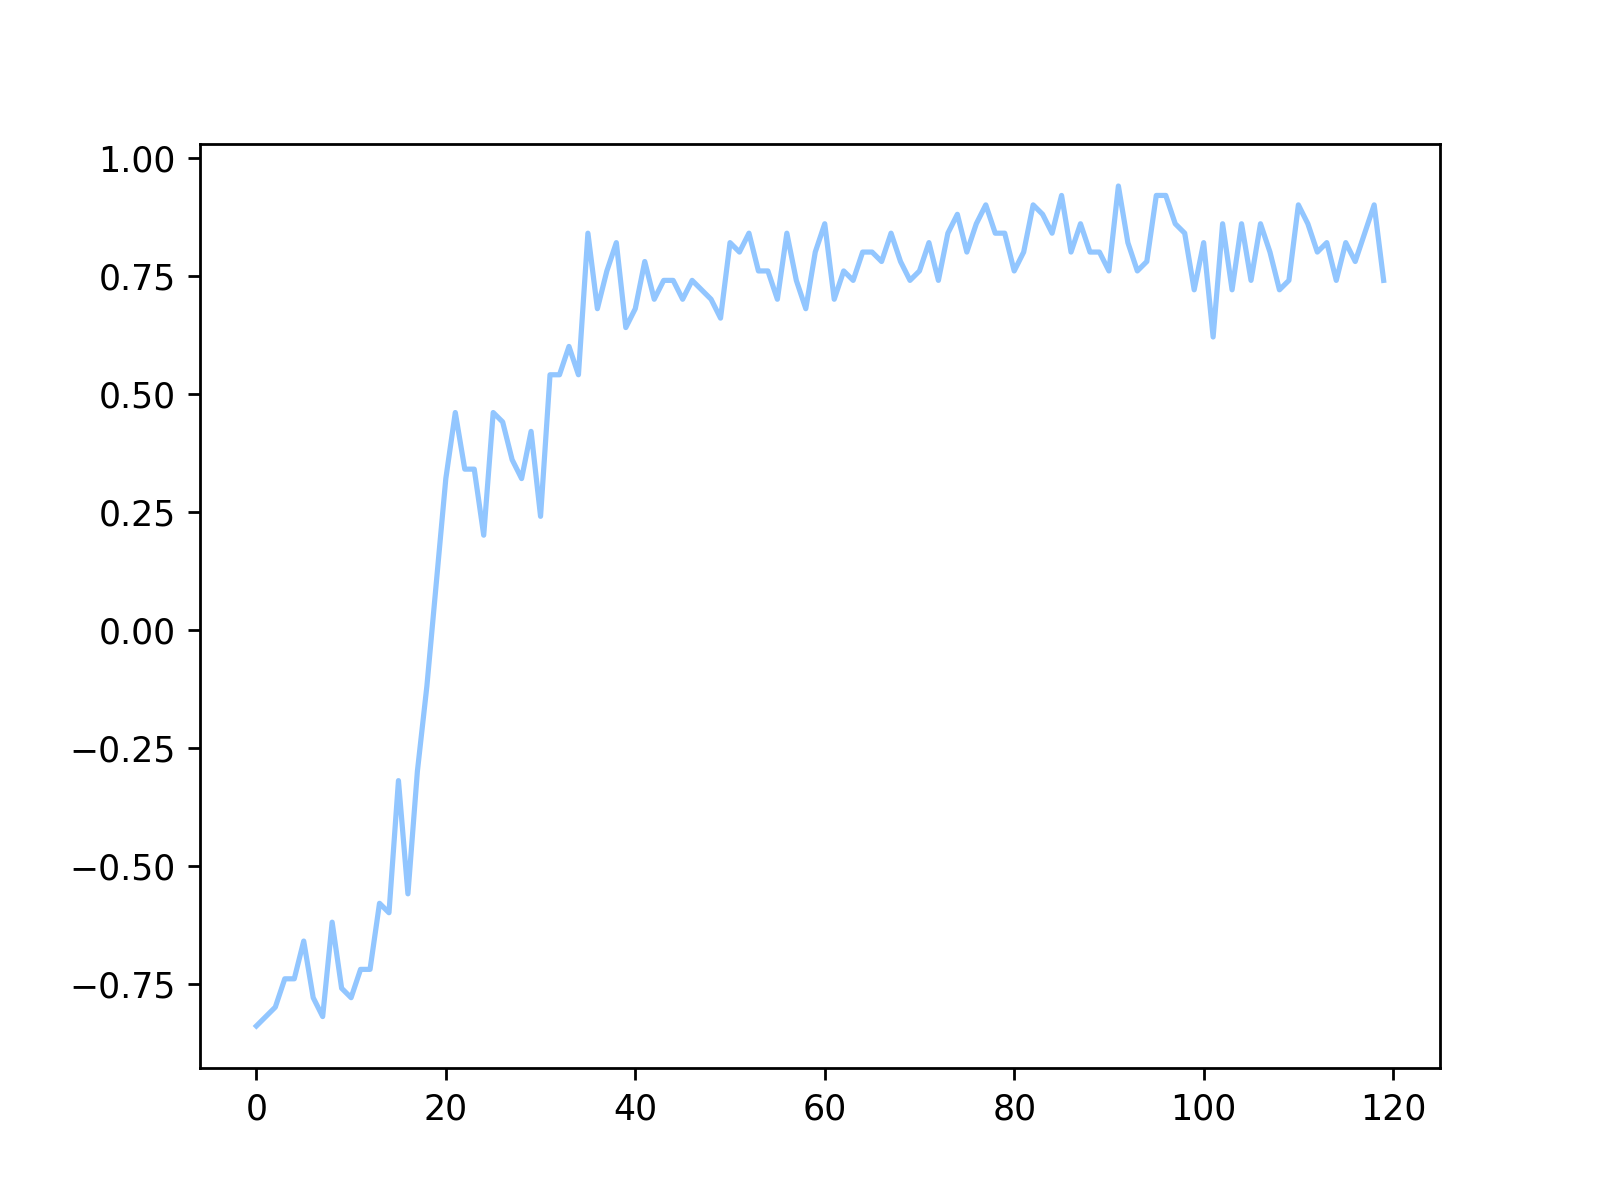

In [11]:
train_curve_pg = np.reshape(reward_log, (-1,100)).mean(axis=1)
plt.plot(train_curve_pg)

In [13]:
# ANIMATE THE POLICY
# The animation may fail because of matplotlib issues,
# Don't hesitate to contact me if so.

def animate(frame):
    
    actions = [[0 for i in range(N)] for N in W.n_agents_each_type] # init actions in right shape
    # Get action for each predator using the model
    for agent_id in range(W.n_agents_each_type[0]):
        state = W.agents['predator'][agent_id].view.ravel()
        state = torch.from_numpy(state).float().to(device)

        probs = model(state)
        m = Categorical(probs)
        action_sample = m.sample()
        action = action_sample.item()
        actions[0][agent_id] = action

    W.transition(actions)
    env_map = W.plot_map(plot=False)
    im.set_data(env_map) 
    return im


In [ ]:
# Animate 6x6 world
W = GridWorld(width=6, height=6, agent_types=AGENT_TYPES, n_agents_each_type=[1,2])

fig = plt.gcf()
im = plt.imshow(W.plot_map(plot=False))
plt.show()
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)

<IPython.core.display.Javascript object>


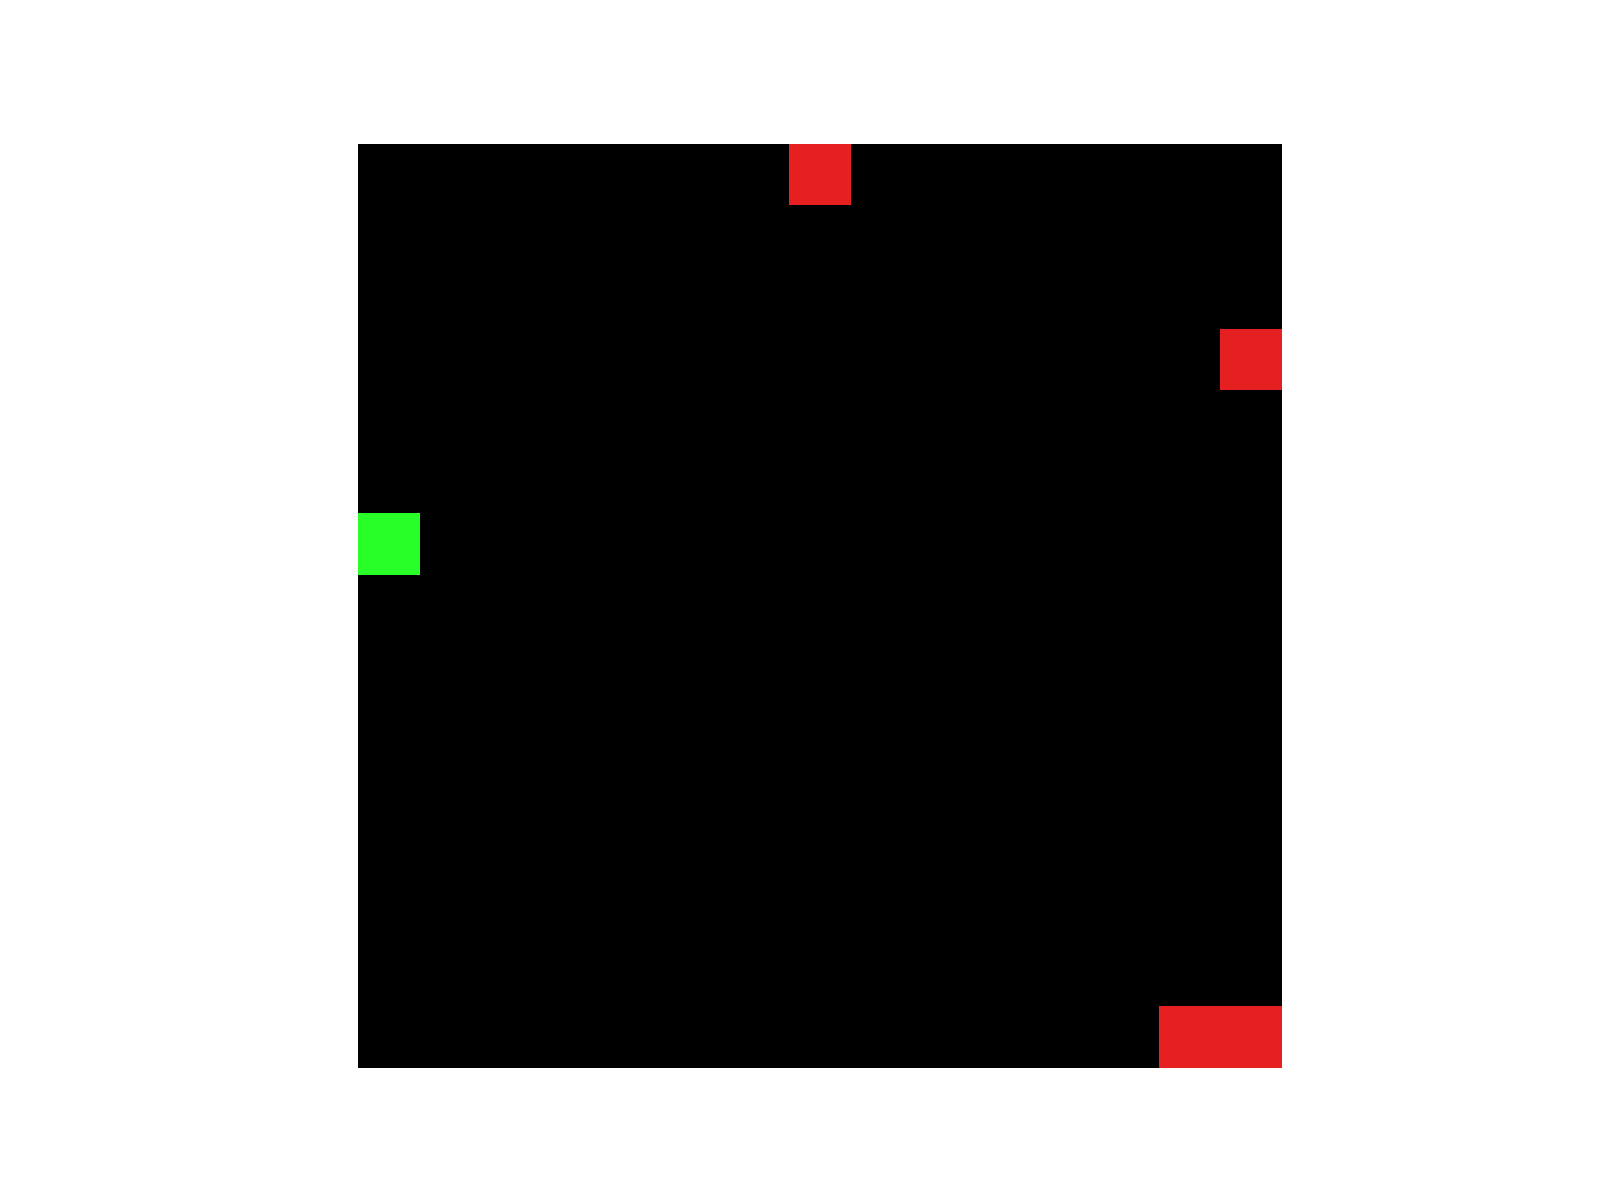

In [14]:
# Animate 15x15 world
W = GridWorld(width=15, height=15, agent_types=AGENT_TYPES, n_agents_each_type=[5,10])

fig = plt.gcf()
im = plt.imshow(W.plot_map(plot=False))
plt.show()
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)